In [3]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import random
import math

from numpy import mean, std
from scipy import stats
import scipy as sp

from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import get_scorer, make_scorer, confusion_matrix, classification_report, recall_score, precision_score, accuracy_score, fbeta_score, roc_curve, roc_auc_score, f1_score, confusion_matrix, mean_squared_error, log_loss
from sklearn import svm, datasets
from sklearn.naive_bayes import BernoulliNB
from sklearn.datasets import make_classification
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import BernoulliNB

from warnings import simplefilter
import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer



simplefilter("ignore", category = ConvergenceWarning)

In [ ]:
path = "/Users/yaeerk/Documents/NAYA/classification/"

In [12]:
df = pd.read_csv('PROTECT_and_RISK_shared_DEGs_NOT NORM.csv', index_col = 0)

### testing if label encoder assigns the right 0,1

In [ ]:
df1 = df.copy()
df1.replace(to_replace ='Control', value = 0, inplace = True)
df1.replace(to_replace = 'UC', value = 1, inplace = True)
arr = np.array(df1.Diagnosis)
arr

In [ ]:
df2 = df.copy()
X = df2.drop('Diagnosis', axis = 1)
y = df2.Diagnosis
y = LabelEncoder().fit_transform(y)
y

# Modeling

In [13]:
X = df.drop('Diagnosis', axis = 1)
y = df.Diagnosis
y = LabelEncoder().fit_transform(y)
numerical_cols = X.columns.to_list()

In [14]:
def f_beta(y_true, y_pred):
    f_beta_score = fbeta_score(y_test, y_test_pred, beta = 0.8)
    return f_beta_score

In [15]:
def my_f2_scorer():
    return make_scorer(f_beta)

In [16]:
tab = "  "
testsizes = [0.2,0.08, 0.1, 0.15, 0.2]
randomstates = [132, 400, 1440]
jobs = 8

In [17]:
outlier_and_norm_transformer = Pipeline(steps = [('imputer', RobustScaler(quantile_range = (1, 99)))])    
preprocessor = ColumnTransformer(transformers = [('num', outlier_and_norm_transformer, numerical_cols)])

### Cross val and Grid search

Using different weights

In [9]:
scores = ['f1', 'accuracy', my_f2_scorer()]

# Define params for each classifier type
grid_params_lr = [ {'clf__C'            : [0.001, 1, 1.5],
                    'clf__solver'       : ['liblinear'],
                    'clf__max_iter'     : [100],
                    'clf__class_weight':['balanced', {0:100,1:1},{0:25,1:1},{0:20,1:1},{0:10,1:1}, {0:9,1:1}, {0:5,1:1}, {0:3,1:1}] }]
                   

grid_params_svc = [ {'clf__kernel'       : ['linear', 'rbf','poly'],
                     'clf__C'            : [0.5, 1.5],
                     'clf__max_iter'     : [100],
                     'clf__class_weight':['balanced', {0:100,1:1},{0:25,1:1},{0:20,1:1},{0:10,1:1}, {0:9,1:1}, {0:5,1:1}, {0:3,1:1}]}]

grid_params_dt = [ {'clf__max_depth'        : [30, 20],
                    'clf__min_samples_leaf' : [10, 3],
                    'clf__class_weight':['balanced', {0:100,1:1},{0:25,1:1},{0:20,1:1},{0:10,1:1}, {0:9,1:1}, {0:5,1:1}, {0:3,1:1}]}]

grid_params_NB = [ {'clf__alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}]

cls_params = [(LogisticRegression(),     grid_params_lr),
              (SVC(),                    grid_params_svc),
              (DecisionTreeClassifier(), grid_params_dt),
              (BernoulliNB(),            grid_params_NB)]
    
for testsize in testsizes:
    print(f"test size: {testsize}")
    
    for randomstate in randomstates:
        print(tab * 2 + f"random state: {randomstate}")
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = randomstate)


        # Run Grid search for each classifier
        for classifier, grid_params in cls_params: 
            
            classifier_type = type(classifier)
            print(tab * 3 + f"{classifier_type}")
            pipeline = Pipeline(steps = [('preprocess', preprocessor), ('clf', classifier)])        
            cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 1)

            # define grid search
            for score in scores:
                print(tab * 4 + f"score: {score}")

                grid = GridSearchCV(pipeline, param_grid = grid_params, scoring = score, cv = cv, n_jobs = jobs)
                grid = grid.fit(X_train, y_train)
                y_test_pred, y_train_pred = grid.predict(X_test), grid.predict(X_train)

                # report the best configuration
                print(tab * 5 + "Best score: %f using %s" % (grid.best_score_, grid.best_params_))
                
                score_train = grid.score(X_train, y_train)
                score_test  = grid.score(X_test, y_test)

                print(tab * 5 + "train score", score_train)
                print(tab * 5 + "test  score", score_test) 


test size: 0.2
    random state: 132
      <class 'sklearn.linear_model._logistic.LogisticRegression'>
        score: f1
          Best score: 0.971231 using {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__max_iter': 100, 'clf__solver': 'liblinear'}
          train score 1.0
          test  score 0.9702970297029703
        score: accuracy
          Best score: 0.957231 using {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__max_iter': 100, 'clf__solver': 'liblinear'}
          train score 1.0
          test  score 0.9538461538461539
        score: make_scorer(f_beta)
          Best score: 0.976665 using {'clf__C': 0.001, 'clf__class_weight': 'balanced', 'clf__max_iter': 100, 'clf__solver': 'liblinear'}
          train score 0.9052234787291331
          test  score 0.9052234787291331
      <class 'sklearn.svm._classes.SVC'>
        score: f1
          Best score: 0.980103 using {'clf__C': 1.5, 'clf__class_weight': {0: 5, 1: 1}, 'clf__kernel': 'poly', 'clf__max_iter': 100}
      

KeyboardInterrupt: ignored

Using SMOTE

In [ ]:
scores = ['f1', 'accuracy', my_f2_scorer()]

# Define params for each classifier type
grid_params_lr = [ {'clf__C'            : [0.001, 1, 1.5],
                    'clf__solver'       : ['liblinear'],
                    'clf__max_iter'     : [100],
                    'clf__class_weight':['balanced']
                    }]

grid_params_svc = [ {'clf__kernel'       : ['linear', 'rbf','poly'],
                     'clf__C'            : [0.5, 1.5],
                     'clf__max_iter'     : [100],
                     'clf__class_weight':['balanced']}]

grid_params_dt = [ {'clf__max_depth'        : [30, 20],
                    'clf__min_samples_leaf' : [10, 3],
                    'clf__class_weight':['balanced']}]

grid_params_NB = [ {'clf__alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}]

cls_params = [(LogisticRegression(),     grid_params_lr),
              (SVC(),                    grid_params_svc),
              (DecisionTreeClassifier(), grid_params_dt),
              (BernoulliNB(),            grid_params_NB)]
    
for testsize in testsizes:
    print(f"test size: {testsize}")
    
    for randomstate in randomstates:
        print(tab * 2 + f"random state: {randomstate}")
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = randomstate)

        smote = SMOTE(random_state = randomstate)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Run Grid search for each classifier
        for classifier, grid_params in cls_params: 
            
            classifier_type = type(classifier)
            print(tab * 3 + f"{classifier_type}")
            pipeline = Pipeline(steps = [('preprocess', preprocessor), ('clf', classifier)])        
            cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 1)

            # define grid search
            for score in scores:
                print(tab * 4 + f"score: {score}")

                grid = GridSearchCV(pipeline, param_grid = grid_params, scoring = score, cv = cv, n_jobs = jobs)
                grid = grid.fit(X_train, y_train)
                y_test_pred, y_train_pred = grid.predict(X_test), grid.predict(X_train)

                # report the best configuration
                print(tab * 5 + "Best score: %f using %s" % (grid.best_score_, grid.best_params_))
                
                score_train = grid.score(X_train, y_train)
                score_test  = grid.score(X_test, y_test)

                print(tab * 5 + "train score", score_train)
                print(tab * 5 + "test  score", score_test) 


test size: 0.2
    random state: 132
      <class 'sklearn.linear_model._logistic.LogisticRegression'>
        score: f1
          Best score: 0.979200 using {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__max_iter': 100, 'clf__solver': 'liblinear'}
          train score 1.0
          test  score 0.9702970297029703
        score: accuracy
          Best score: 0.979808 using {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__max_iter': 100, 'clf__solver': 'liblinear'}
          train score 1.0
          test  score 0.9538461538461539
        score: make_scorer(f2_func)
          Best score: 0.976665 using {'clf__C': 0.001, 'clf__class_weight': 'balanced', 'clf__max_iter': 100, 'clf__solver': 'liblinear'}
          train score 0.9649375600384248
          test  score 0.9649375600384248
      <class 'sklearn.svm._classes.SVC'>
        score: f1
          Best score: 0.984467 using {'clf__C': 0.5, 'clf__class_weight': 'balanced', 'clf__kernel': 'linear', 'clf__max_iter': 100}
     

KeyboardInterrupt: ignored

        LogisticRegression


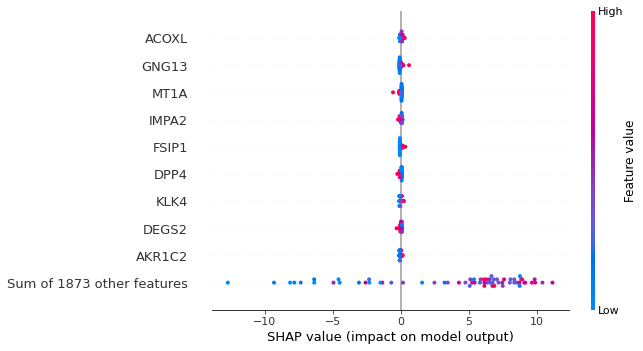

None


In [21]:
# SHAP visualization for LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=250)
smote = SMOTE(random_state = 250)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)
                                    
X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

clf = LogisticRegression( solver = 'liblinear',C= 1, max_iter=100).fit(X_train, y_train) 

explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

print('        LogisticRegression')  
print(f'{shap.plots.beeswarm(shap_values)}')

   Random Forest


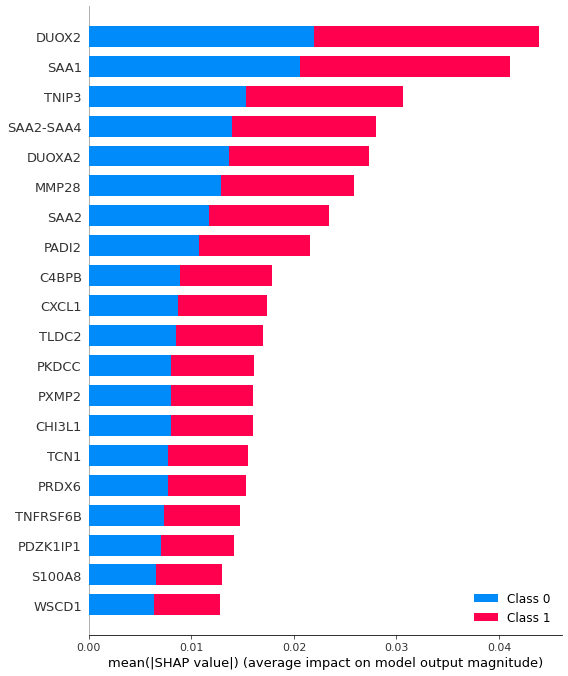

In [22]:
# SHAP visualization for SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1850)
smote = SMOTE(random_state = 1850)

X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)
                                    
X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)


rf = RandomForestClassifier(max_depth= 10, min_samples_leaf= 3)
rf.fit(X_train,y_train)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)


#shap.summary_plot(shap_values, X_train, plot_type="bar")
print('   Random Forest')
shap.summary_plot(shap_values, X_train)

#print('          RF')    
#print(f'{shap.plots.beeswarm(shap_values)}')

   Random Forest


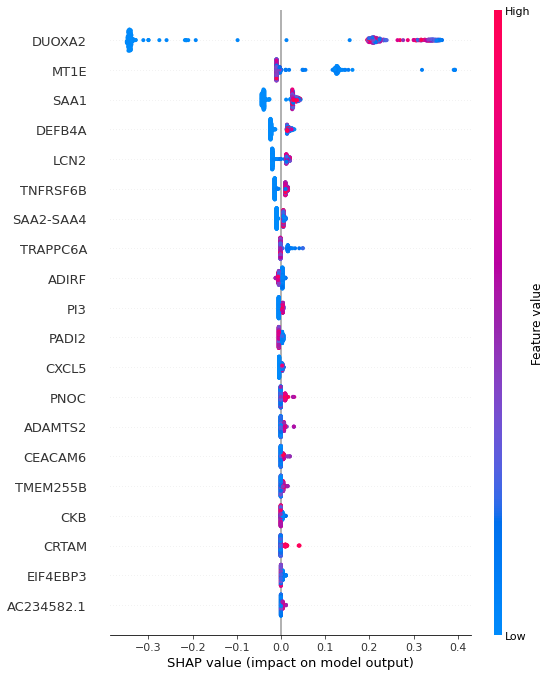

In [19]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1850)
smote = SMOTE(random_state = 1850)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)
                                    
X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)


rf = RandomForestRegressor(max_depth= 10, min_samples_leaf= 3)
rf.fit(X_train,y_train)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)


#shap.summary_plot(shap_values, X_train, plot_type="bar")
print('   Random Forest')
shap.summary_plot(shap_values, X_train)


In [ ]:
clf = RandomForestClassifier().fit(X_train, y_train) 

#explainer = shap.TreeExplainer(clf, X_train)
#shap_values = explainer(X_test)



masker = shap.maskers.Independent(X_train)
explainer = shap.TreeExplainer(clf, masker)

# shap_values.values.shape ==  (10000, 41, 2)
# shap_values[1].values.shape == (41, 2)
shap_values = explainer(clf, X_train)

# tmp.values.shape == tmp.data.shape == (10000, 41)
# I took all observations for all features just for positive prediction result
tmp = shap.Explanation(shap_values[:, :, 1], data=X_train, feature_names= X.columns)

# now both plots work
shap.plots.beeswarm(tmp)
#shap.summary_plot(tmp)


          SVC


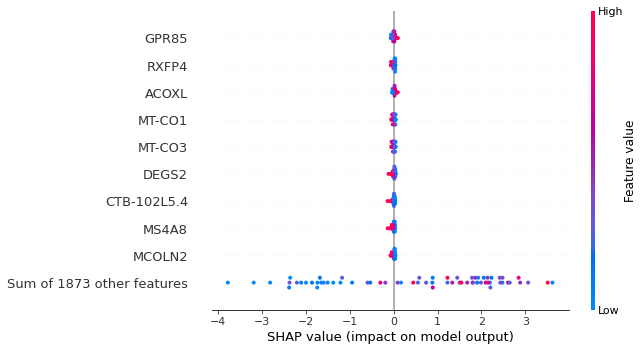

None


In [20]:
# SHAP visualization for SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1050)
smote = SMOTE(random_state = 1050)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)
                                    
X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)


clf = SVC( kernel ='linear',C= 1, max_iter=100).fit(X_train, y_train) 

explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

print('          SVC')    
print(f'{shap.plots.beeswarm(shap_values)}')

### **Voting**

In [ ]:

scores = ['f1', 'accuracy', my_f2_scorer()]

# Define params for each classifier type

clf_lr = LogisticRegression(C=1,solver='liblinear',max_iter= 100,class_weight ='balanced')
clf_svc = SVC(kernel ='linear',C = 1,max_iter=100,class_weight='balanced', probability=True)
clf_dt = DecisionTreeClassifier(max_depth=30,min_samples_leaf=15)

params = [clf_lr, clf_svc, clf_dt]

classifiers = [('LR',clf_lr),
               ('SVC',clf_svc),
               ('DT',clf_dt)]

for testsize in testsizes:

  print(f"test size: {testsize}")
    
  for randomstate in randomstates:
        print(tab * 2 + f"random state: {randomstate}")
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = randomstate)
                     
        smote = SMOTE(random_state = randomstate)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        robustscaler = RobustScaler(quantile_range = (1, 99))
        robustscaler.fit(X_train)
                                    
        X_train = robustscaler.transform(X_train)
        X_test  = robustscaler.transform(X_test)

       #Voting
        
        # Voting Classifier with hard voting
        print(tab * 3 + f"Hard voting")
        
        vot_hard = VotingClassifier(estimators = classifiers, voting ='hard')
        vot_hard = vot_hard.fit(X_train, y_train)
        
        vot_hard_test = vot_hard.fit(X_test, y_test)
        y_test_pred_h = vot_hard_test.predict(X_test)
        
         # using accuracy_score, log_loss and f1_score metrics to predict accuracy
        acc = accuracy_score(y_test, y_test_pred_h)
        l_loss = log_loss(y_test, y_test_pred_h)
        f1 = f1_score(y_test, y_test_pred_h)
        f2 = fbeta_score(y_test, y_test_pred_h, beta = 0.8)
       
        print(tab * 4 + f"Accuracy is: {acc}")
        print(tab * 4 + f"Log Loss is: {l_loss}")
        print(tab * 4 + f"F1 Score is: {f1}")
        print(tab * 4 + f"F beta Score is: {f2}")

        # Voting Classifier with soft voting
        print(tab * 3 + f"Soft voting")
        
        vot_soft = VotingClassifier(estimators = classifiers, voting ='soft')
        vot_soft = vot_soft.fit(X_train, y_train)

        vot_soft_test = vot_soft.fit(X_test, y_test)
        y_test_pred = vot_soft_test.predict(X_test)
          
        # using accuracy_score, log_loss and f1_score metrics to predict accuracy
        acc = accuracy_score(y_test, y_test_pred)
        l_loss = log_loss(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        f2 = fbeta_score(y_test, y_test_pred, beta = 0.8)
       
        print(tab * 4 + f"Accuracy is: {acc}")
        print(tab * 4 + f"Log Loss is: {l_loss}")
        print(tab * 4 + f"F1 Score is: {f1}")
        print(tab * 4 + f"F beta Score is: {f2}")


        cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 1)

        scores = ['f1', 'accuracy'] #, my_f2_scorer()
        for score in scores:
          print(tab * 4 + f"score: {score}")

          labels = ['Logistic Regression', 'SVC', 'DT', 'hard_ensamble', 'soft_ensamble'] 
          params = [clf_lr, clf_svc, clf_dt, vot_hard, vot_soft ]
          for clf in params :
            cv_results = cross_validate(clf, X_train, y_train, cv = cv, scoring = scores, return_train_score = True, n_jobs = jobs)
    
          k_ave = [np.mean(value) for value in cv_results.values()]
          k_std = [np.std(value) for value in cv_results.values()]
          for k,std,lable in zip(k_ave,k_std, labels) :
            print(tab * 5 +"train score: %0.5f (+/- %0.3f) [%s]" % (k, std, lable))

          



  

test size: 0.2
    random state: 132
      Hard voting
        Accuracy is: 1.0
        Log Loss is: 9.992007221626415e-16
        F1 Score is: 1.0
        F beta Score is: 1.0
      Soft voting
        Accuracy is: 1.0
        Log Loss is: 9.992007221626415e-16
        F1 Score is: 1.0
        F beta Score is: 1.0
        score: f1
          train score: 1.16519 (+/- 0.061) [Logistic Regression]
          train score: 0.01987 (+/- 0.007) [SVC]
          train score: 0.97701 (+/- 0.005) [DT]
          train score: 1.00000 (+/- 0.000) [hard_ensamble]
          train score: 0.97718 (+/- 0.005) [soft_ensamble]
        score: accuracy
          train score: 1.12656 (+/- 0.090) [Logistic Regression]
          train score: 0.01445 (+/- 0.004) [SVC]
          train score: 0.98208 (+/- 0.006) [DT]
          train score: 1.00000 (+/- 0.000) [hard_ensamble]
          train score: 0.98225 (+/- 0.006) [soft_ensamble]
    random state: 400
      Hard voting
        Accuracy is: 1.0
        Log Loss

### **Bagging**

In [ ]:

scores = ['f1', 'accuracy', my_f2_scorer()]

# Define params for each classifier type
grid_params_lr = {  'base_estimator__C'            : [1], # 0.001, 1.5
                    'base_estimator__solver'       : ['liblinear'],
                    'base_estimator__max_iter'     : [100],
                    'base_estimator__class_weight' : ['balanced'],
                    'bootstrap'          : [True, False],
                    'bootstrap_features' : [True, False],    
                    'n_estimators'       : [2], #, 10, 20, 30
                    'max_samples'        : [0.6]} #, 0.8, 1.0

grid_params_svc =  {'base_estimator__kernel'        : ['linear', 'rbf'],
                    'base_estimator__C'            : [1], # 0.001, 1.5
                    'base_estimator__max_iter'     : [100],
                    'base_estimator__class_weight' : ['balanced'],
                    'bootstrap'          : [True, False],
                    'bootstrap_features' : [True, False],    
                    'n_estimators'       : [2], #, 10, 20, 30
                    'max_samples'        : [0.6]} #, 0.8, 1.0

params_rf = {'max_depth': [30], #,20, 10
                  'n_estimators':[2], #20,50,100
                   'min_samples_leaf': [10,3],
                   'class_weight':['balanced']}  


clf_lr = LogisticRegression()
clf_svc = SVC()
clf_dt = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()
              
  
for testsize in testsizes:

  print(f"test size: {testsize}")
    
  for randomstate in randomstates:
        print(tab * 2 + f"random state: {randomstate}")
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = randomstate)
                     
        smote = SMOTE(random_state = randomstate)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        robustscaler = RobustScaler(quantile_range = (1, 99))
        robustscaler.fit(X_train)
                                    
        X_train = robustscaler.transform(X_train)
        X_test  = robustscaler.transform(X_test)

        # Run Grid search for each classifier

        print(tab * 3 + f"{ LogisticRegression}")

            # define grid search
        for score in scores:
                print(tab * 4 + f"score: {score}")
                cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = randomstate)

                bgclassifier_lr = BaggingClassifier(base_estimator = LogisticRegression(), n_jobs = jobs)

                    #build the params +  base_estimator params
             
                grid = GridSearchCV(bgclassifier_lr, param_grid = grid_params_lr, cv = cv, n_jobs = jobs, scoring = score)                                    
                grid = grid.fit(X_train, y_train) 
                                                                
                y_train_pred = grid.predict(X_train)
                y_test_pred  = grid.predict(X_test)
                                                                    
                    #report the best configuration
                print(tab * 6 + "Best score: %f using %s" % (grid.best_score_, grid.best_params_))

                score_train = grid.score(X_train, y_train)
                score_test  = grid.score(X_test, y_test)

                print(tab * 6 + "train score", score_train)
                print(tab * 6 + "test  score", score_test) 

        print(tab * 3 + f"{ SVC}")

            # define grid search
        for score in scores:
                print(tab * 4 + f"score: {score}")
                cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = randomstate)

                bgclassifier_lr = BaggingClassifier(base_estimator = SVC(), n_jobs = jobs)

                    #build the params +  base_estimator params
          
                grid = GridSearchCV(bgclassifier_lr, param_grid = grid_params_svc, cv = cv, n_jobs = jobs, scoring = score)                                    
                grid = grid.fit(X_train, y_train) 
                                                                
                y_train_pred = grid.predict(X_train)
                y_test_pred  = grid.predict(X_test)
                                                                    
                    #report the best configuration
                print(tab * 6 + "Best score: %f using %s" % (grid.best_score_, grid.best_params_))

                score_train = grid.score(X_train, y_train)
                score_test  = grid.score(X_test, y_test)

                print(tab * 6 + "train score", score_train)
                print(tab * 6 + "test  score", score_test) 

#RandomForest==========================================================

        print(tab * 3 + f"{ RandomForestClassifier}")
        for score in scores:
                print(tab * 4 + f"score: {score}")
                cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = randomstate)

                rf_gs = GridSearchCV(clf_rf, params_rf, cv = cv, n_jobs = jobs,scoring = score )
                rf_gs = rf_gs.fit(X_train, y_train)
                y_test_pred, y_train_pred = rf_gs.predict(X_test), rf_gs.predict(X_train)

                  #report the best configuration
                print(tab * 6 + "Best score: %f using %s" % (rf_gs.best_score_, rf_gs.best_params_))

                score_train = rf_gs.score(X_train, y_train)
                score_test  = rf_gs.score(X_test, y_test)

                print(tab * 6 + "train score", score_train)
                print(tab * 6 + "test  score", score_test) 

### ROC AUC

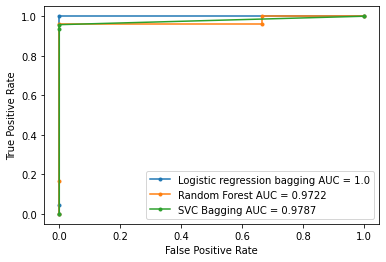

In [17]:
# fit model_a = LR
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=850)
smote = SMOTE(random_state = 850)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)
                                    
X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
clf_base = LogisticRegression(C = 1, solver = 'liblinear', max_iter = 200, class_weight = 'balanced')
model_a = BaggingClassifier(base_estimator=clf_base, bootstrap = True, bootstrap_features = False, 
                            n_estimators = 2, max_samples = 0.6, n_jobs = 8, random_state = 850)
model_a.fit(X_train, y_train)
# predict probabilities
lr_probs_a = model_a.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_a = lr_probs_a[:, 1]
# calculate roc curves
lr_fpr_a, lr_tpr_a, thresholds_a = roc_curve(y_test, lr_probs_a)
# Calculate AUC 
lr_auc_a = roc_auc_score(y_test, lr_probs_a)

# fit model_b = RF
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=650)
smote = SMOTE(random_state = 650)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)
                                    
X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
model_b = RandomForestClassifier(max_depth = 10, min_samples_leaf = 10, random_state = 650)
model_b.fit(X_train, y_train)

lr_probs_b = model_b.predict_proba(X_test)
lr_probs_b = lr_probs_b[:,1]
lr_fpr_b, lr_tpr_b, thresholds_b = roc_curve(y_test, lr_probs_b)
lr_auc_b = roc_auc_score(y_test, lr_probs_b)

# fit model_c = SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=650)
smote = SMOTE(random_state = 650)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)
                                    
X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
clf_base_svc = SVC(kernel = 'rbf', C = 1.5, max_iter = 200, class_weight = 'balanced')
model_c = BaggingClassifier(base_estimator=clf_base_svc, bootstrap = True, bootstrap_features = False, n_estimators = 2, 
                            max_samples =0.6, n_jobs = 8, random_state = 650 )
model_c.fit(X_train, y_train)
lr_probs_c = model_c.predict_proba(X_test)

lr_probs_c = lr_probs_c[:, 1]
lr_fpr_c, lr_tpr_c, thresholds_c = roc_curve(y_test, lr_probs_c)
lr_auc_c = roc_auc_score(y_test, lr_probs_c)


# plot the roc curve for the model
#pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill AUC = {ns_auc :.2}')
pyplot.plot(lr_fpr_a, lr_tpr_a, marker='.', label=f'Logistic regression bagging AUC = {lr_auc_a:.4}')
pyplot.plot(lr_fpr_b, lr_tpr_b, marker='.', label=f'Random Forest AUC = {lr_auc_b:.4}')
pyplot.plot(lr_fpr_c, lr_tpr_c, marker='.', label=f'SVC Bagging AUC = {lr_auc_c:.4}')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
plt.savefig('roc auc.pdf', bbox_inches='tight')
pyplot.show()

ROC AUC after feature selection

In [12]:
def dominant_features(X_train, X_test, y_train, t, n):
    genes = {}
    for r in randomstates:
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = t, random_state = r)

        for depth in range(2, 6, 2):
            dtc = DecisionTreeClassifier(max_depth = depth).fit(X_train, y_train)
            sort_arr = np.argsort(dtc.feature_importances_)

            for i in range(-3, -1, 1):
                gene  = X.columns[sort_arr[i]]
                value = dtc.feature_importances_[sort_arr[i]]
                if(value <= 0):
                    continue

                if(gene in genes):
                    genes[gene] += value
                else:
                    genes[gene] = value

    features = [(k, v) for k, v in sorted(genes.items(), reverse = True, key = lambda item: item[1])]
    feature_names = [k for k, v in features]
    feature_names = feature_names[:n]
    
    return X_train.drop(X_train.columns.difference(feature_names), 1), X_test.drop(X_test.columns.difference(feature_names), 1)

In [14]:
score = 'f1'
features = 50
randomstates = [250, 650, 850, 1050, 1250, 1850, 2050]

#best
testsize, randomstate = 0.15, 850
max_depth, min_samples_leaf = [10, 3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


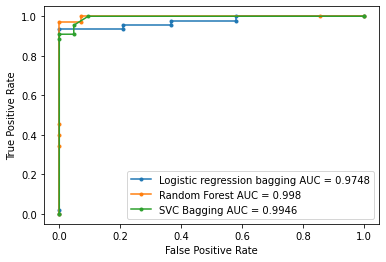

In [18]:
# fit model_a = LR

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1050)
X_train, X_test = dominant_features(X_train, X_test, y_train, 0.2, features)

smote = SMOTE(random_state = 1050)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)
                                    
X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)

clf_base = LogisticRegression(C = 1, solver = 'liblinear', max_iter = 200, class_weight = 'balanced')
model_a = BaggingClassifier(base_estimator=clf_base, bootstrap = True, bootstrap_features = False, 
                            n_estimators = 2, max_samples = 0.8, n_jobs = 8, random_state = 1050)
model_a.fit(X_train, y_train)
lr_probs_a = model_a.predict_proba(X_test)
lr_probs_a = lr_probs_a[:, 1]
lr_fpr_a, lr_tpr_a, thresholds_a = roc_curve(y_test, lr_probs_a)
lr_auc_a = roc_auc_score(y_test, lr_probs_a)

# fit model_b = RF

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 650)
X_train, X_test = dominant_features(X_train, X_test, y_train, 0.15, features)

smote = SMOTE(random_state = 650)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)
                                    
X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)

model_b = RandomForestClassifier(max_depth = 10, min_samples_leaf = 10, random_state = 650)
model_b.fit(X_train, y_train)
lr_probs_b = model_b.predict_proba(X_test)
lr_probs_b = lr_probs_b[:,1]
lr_fpr_b, lr_tpr_b, thresholds_b = roc_curve(y_test, lr_probs_b)
lr_auc_b = roc_auc_score(y_test, lr_probs_b)


# fit model_c= SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1850)
X_train, X_test = dominant_features(X_train, X_test, y_train, 0.2, features)

smote = SMOTE(random_state = 1850)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)
                                    
X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)

clf_base_svc = SVC(kernel = 'linear', C = 1.5, max_iter = 200, class_weight = 'balanced')
model_c = BaggingClassifier(base_estimator=clf_base_svc, bootstrap = True, bootstrap_features = False, n_estimators = 20, 
                            max_samples =0.8, n_jobs = 8, random_state = 1850 )
model_c.fit(X_train, y_train)
lr_probs_c = model_c.predict_proba(X_test)


# keep probabilities for the positive outcome only

lr_probs_c = lr_probs_c[:, 1]
lr_fpr_c, lr_tpr_c, thresholds_c = roc_curve(y_test, lr_probs_c)
lr_auc_c = roc_auc_score(y_test, lr_probs_c)


# plot the roc curve for the model
#pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill AUC = {ns_auc :.2}')
pyplot.plot(lr_fpr_a, lr_tpr_a, marker='.', label=f'Logistic regression bagging AUC = {lr_auc_a:.4}')
pyplot.plot(lr_fpr_b, lr_tpr_b, marker='.', label=f'Random Forest AUC = {lr_auc_b:.4}')
pyplot.plot(lr_fpr_c, lr_tpr_c, marker='.', label=f'SVC Bagging AUC = {lr_auc_c:.4}')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
plt.savefig('roc auc reduction.pdf', bbox_inches='tight')
pyplot.show()